In [108]:
import pandas as pd
import numpy as np

%run ../src/preprocessing/initial_prep.py


# will create Train_df
# will create Test_df

<Figure size 432x288 with 0 Axes>

In [109]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion,Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn import set_config
set_config(display ="diagram")

import matplotlib.pyplot as plt
%matplotlib inline


In [127]:
def explore_cat_vars(df, n):
    col_counts=pd.DataFrame(df.nunique(),).reset_index()
    col_counts.columns=(["Col_Name", "Count"])
    for col in col_counts[col_counts['Count'] < n]['Col_Name']:
        print('--------------------------------------')
        print(col)
        print('--------------------------------------')
        print(df[col].value_counts())
    print("=================================================================================================")
    print(col_counts[col_counts['Count'] >= n])
    
#explore_cat_vars(train_df, 42)
#explore_cat_vars(train_df, 42)
train_df.shape
test_df.shape


(76732, 153)

In [128]:
train_sample=train_df.sample(230000)
test_sample=test_df.sample(75000)

#test=get_unknown(test_df).sample(8000)
#pd.Series(train_sample.columns)

In [114]:

#df.dropna(subset=['AGE_GROUP','DRIVERS_LICENSE_CLASS'], inplace=True)

y_train = train_sample['GUILTY']
X_train = train_sample.drop(columns = 'GUILTY')

y_test = test_sample['GUILTY']
X_test = test_sample.drop(columns = 'GUILTY')


In [115]:
#ordinal_columns = ['DRIVERS_LICENSE_CLASS']
nominal_columns = ['DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 
           'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','ROAD_DEFECT','POSTED_SPEED_LIMIT','VEHICLE_DEFECT',
            'ALIGNMENT', 'LIGHTING_CONDITION', 'WEATHER_CONDITION','SEX','DRIVERS_LICENSE_CLASS', 'AGE_GROUP', 
            'PHYSICAL_CONDITION', 'MANEUVER',  'DRIVER_VISION', 'VEHICLE_YEAR', 'VEHICLE_AGE', 'TRAFFIC_CONTROL_DEVICE',
     ]

numeric_columns = ['NUM_PASSENGERS']

nominal_columns = ['DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 
           'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','VEHICLE_DEFECT',
             'DRIVERS_LICENSE_CLASS', 'AGE_GROUP', 'VEHICLE_AGE', 'AIRBAG_DEPLOYED',
            'PHYSICAL_CONDITION', 'MANEUVER',  'DRIVER_VISION',  'ALIGNMENT',  'TRAFFIC_CONTROL_DEVICE']



In [116]:
from sklearn.pipeline import FeatureUnion

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numeric_columns)),
        ('imputer', SimpleImputer(strategy = 'constant', fill_value=0)),
        ('std_scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(nominal_columns)),
        ('imputer', SimpleImputer(strategy = 'constant', fill_value='NA')),
        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
    ])


fu = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


X_train_transformed = fu.fit_transform(X_train)
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 230000 entries, 184979 to 481791
Columns: 152 entries, PERSON_ID to SOME_DRIVER_SEC_ERROR
dtypes: category(2), float64(23), int64(8), object(119)
memory usage: 265.4+ MB


In [117]:
columns=fu.transformer_list[1][1][2].get_feature_names_out()
columns=np.insert(columns, 0, 'Intercept')
transformed_df=pd.DataFrame(X_train_transformed, columns=columns)
transformed_df

#transformed_df.info(verbose=True, show_counts=True)






,Intercept,x0_FUNCTIONING IMPROPERLY,x0_FUNCTIONING PROPERLY,x0_MISSING,x0_NO CONTROLS,x0_NOT FUNCTIONING,x0_OTHER,x0_WORN REFLECTIVE MATERIAL,x1_ANGLE,x1_ANIMAL,x1_FIXED OBJECT,x1_HEAD ON,x1_OTHER NONCOLLISION,x1_OTHER OBJECT,x1_OVERTURNED,x1_PARKED MOTOR VEHICLE,x1_PEDALCYCLIST,x1_PEDESTRIAN,x1_REAR END,x1_REAR TO FRONT,x1_REAR TO REAR,x1_REAR TO SIDE,x1_SIDESWIPE OPPOSITE DIRECTION,x1_SIDESWIPE SAME DIRECTION,x1_TRAIN,x1_TURNING,x2_FRONT,x2_FRONT-LEFT,x2_FRONT-RIGHT,x2_NONE,x2_OTHER,x2_REAR,x2_REAR-LEFT,x2_REAR-RIGHT,x2_ROOF,x2_SIDE-LEFT,x2_SIDE-RIGHT,x2_TOTAL (ALL AREAS),x2_UNDER CARRIAGE,x3_ALLEY,...,x11_TURNING ON RED,x11_TURNING RIGHT,x11_U-TURN,x12_BLINDED - HEADLIGHTS,x12_BLINDED - SUNLIGHT,x12_BLOWING MATERIALS,x12_BUILDINGS,x12_EMBANKMENT,x12_HILLCREST,x12_MOVING VEHICLES,x12_NOT OBSCURED,x12_OTHER,x12_PARKED VEHICLES,x12_SIGNBOARD,"x12_TREES, PLANTS",x12_WINDSHIELD (WATER/ICE),x13_CURVE ON GRADE,x13_CURVE ON HILLCREST,"x13_CURVE, LEVEL",x13_STRAIGHT AND LEVEL,x13_STRAIGHT ON GRADE,x13_STRAIGHT ON HILLCREST,x14_BICYCLE CROSSING SIGN,x14_DELINEATORS,x14_FLASHING CONTROL SIGNAL,x14_LANE USE MARKING,x14_NO CONTROLS,x14_NO PASSING,x14_OTHER,x14_OTHER RAILROAD CROSSING,x14_OTHER REG. SIGN,x14_OTHER WARNING SIGN,x14_PEDESTRIAN CROSSING SIGN,x14_POLICE/FLAGMAN,x14_RAILROAD CROSSING GATE,x14_RR CROSSING SIGN,x14_SCHOOL ZONE,x14_STOP SIGN/FLASHER,x14_TRAFFIC SIGNAL,x14_YIELD
0,-0.380638,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.380638,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.872105,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.380638,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.380638,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229995,-0.380638,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229996,-0.380638,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0

In [118]:

baseline_pipe = Pipeline([ ('fu', fu),
                          ('onehotenc', OneHotEncoder(sparse = False, drop = 'first', handle_unknown =  'ignore')),
#                          ('standardscale', StandardScaler()),
                          ('model',LogisticRegression(max_iter = 10000, solver = 'newton-cg'))])
#baseline_pipe.fit(X_train, y_train)
###y_pred_test = baseline_pipe.predict(X_test)
#y_pred_train = baseline_pipe.predict(X_train)

#print('Precision : ', precision_score(y_train, y_pred_train, pos_label="NO"),
#      '\n Recall score: ', recall_score(y_train, y_pred_train, pos_label="NO"),
#      '\n Accuracy Score :', accuracy_score(y_train, y_pred_train,))
#print('------------')
#print('Precision : ', precision_score(y_test, y_pred_test, pos_label="NO"),
#      '\n Recall score: ', recall_score(y_test, y_pred_test, pos_label="NO"),
#      '\n Score :', accuracy_score(y_test, y_pred_test,))

In [121]:
pipe_grid = {'model__solver': ['newton-cg','lbfgs']}
gs_pipe = GridSearchCV(estimator=baseline_pipe, param_grid=pipe_grid, cv=2)
gs_pipe

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('fu',
                                        FeatureUnion(transformer_list=[('num_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['NUM_PASSENGERS'])),
                                                                                        ('imputer',
                                                                                         SimpleImputer(fill_value=0,
                                                                                                       strategy='constant')),
                                                                                        ('std_scaler',
                                                                                         StandardScaler())])),
                                                                       ('cat_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_nam...
                                                                                                                            'TRAFFIC_CONTROL_DEVICE'])),
                                                                                        ('imputer',
                                                                                         SimpleImputer(fill_value='NA',
                                                                                                       strategy='constant')),
                                                                                        ('cat_encoder',
                                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                                       sparse=False))]))])),
                                       ('onehotenc',
                                        OneHotEncoder(drop='first',
                                                      handle_unknown='ignore',
                                                      sparse=False)),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           solver='newton-cg'))]),
             param_grid={'model__solver': ['newton-cg', 'lbfgs']})

In [122]:
gs_pipe.fit(X_train, y_train)

C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('fu',
                                        FeatureUnion(transformer_list=[('num_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['NUM_PASSENGERS'])),
                                                                                        ('imputer',
                                                                                         SimpleImputer(fill_value=0,
                                                                                                       strategy='constant')),
                                                                                        ('std_scaler',
                                                                                         StandardScaler())])),
                                                                       ('cat_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_nam...
                                                                                                                            'TRAFFIC_CONTROL_DEVICE'])),
                                                                                        ('imputer',
                                                                                         SimpleImputer(fill_value='NA',
                                                                                                       strategy='constant')),
                                                                                        ('cat_encoder',
                                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                                       sparse=False))]))])),
                                       ('onehotenc',
                                        OneHotEncoder(drop='first',
                                                      handle_unknown='ignore',
                                                      sparse=False)),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           solver='newton-cg'))]),
             param_grid={'model__solver': ['newton-cg', 'lbfgs']})

In [123]:
gs_pipe.best_params_

{'model__solver': 'newton-cg'}

In [124]:
y_pred_train=gs_pipe.predict(X_train)


In [125]:
print('Precision : ', precision_score(y_train, y_pred_train, pos_label="NO"),
      '\n Recall score: ', recall_score(y_train, y_pred_train, pos_label="NO"),
      '\n Score :', accuracy_score(y_train, y_pred_train,))
print('------------')
#print('Precision : ', precision_score(y_test, y_pred_test, pos_label="NO"),
#     '\n Recall score: ', recall_score(y_test, y_pred_test, pos_label="NO"),
#      '\n Score :', accuracy_score(y_test, y_pred_test,))

Precision :  0.81957569309719 
 Recall score:  0.8731248749916661 
 Score : 0.7919130434782609
------------


Precision :  0.7814858326198204 
 Recall score:  0.8385752745609162 
 Accuracy Score : 0.7683875
------------


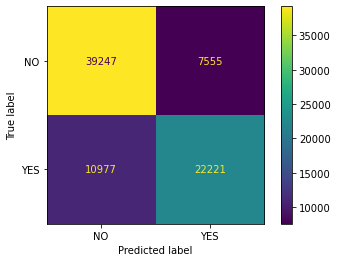

In [92]:

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)

In [94]:
#pd.Series(gs_pipe.estimator.get_params().items())

In [ ]:
#pipe_grid = {'model__max_depth': [ 7,8, 9, 10,11],
#            'model__min_samples_split':[6,7,8,9],'model__min_samples_leaf':[11,12,13]}

pipe_grid = {'model__criterion': ['gini', 'entropy']}



gs_pipe = GridSearchCV(estimator=baseline_tree_pipe, 
                       param_grid=pipe_grid, cv=10)

In [ ]:
gs_pipe.fit(X_train, y_train)

In [ ]:
y_pred_train=gs_pipe.predict(X_train)
#y_pred_test=gs_pipe.predict(X_test)

In [ ]:
print('Precision : ', precision_score(y_train, y_pred_train, pos_label="NO"),
      '\n Recall score: ', recall_score(y_train, y_pred_train, pos_label="NO"),
      '\n Score :', accuracy_score(y_train, y_pred_train,))
print('------------')
#print('Precision : ', precision_score(y_test, y_pred_test, pos_label="NO"),
#      '\n Recall score: ', recall_score(y_test, y_pred_test, pos_label="NO"),
#      '\n Score :', accuracy_score(y_test, y_pred_test,))

In [ ]:
baseline_tree_pipe = Pipeline([('preproc', preproc),
                          ('onehotenc', OneHotEncoder(sparse = False, drop = 'first', handle_unknown =  'ignore')),
                          ('standardscale', StandardScaler()),
                          ('model',DecisionTreeClassifier(splitter='best', max_depth=9,
                                                                  min_samples_split=6, min_samples_leaf=12))
                              ])

In [ ]:
baseline_tree_pipe.fit(X_train, y_train)

In [ ]:
#y_pred_test = baseline_tree_pipe.predict(X_test)
y_pred_train = baseline_tree_pipe.predict(X_train)

In [ ]:
print('Precision : ', precision_score(y_train, y_pred_train, pos_label="NO"),
      '\n Recall score: ', recall_score(y_train, y_pred_train, pos_label="NO"),
      '\n Score :', accuracy_score(y_train, y_pred_train,))
print('------------')
#print('Precision : ', precision_score(y_test, y_pred_test, pos_label="NO"),
##      '\n Recall score: ', recall_score(y_test, y_pred_test, pos_label="NO"),
#      '\n Score :', accuracy_score(y_test, y_pred_test,))